# Incorporating DeHazing Features into Low Light Images

Images that are captured outdoors are degraded due to poor lighting conditions. To enhance low-light images, we could do the following steps: 
1. Invert the low light image 
2. Apply a haze removal algorithm to the inverted low-light image
3. Invert the enhanced image. 

While steps 1 and 3 are extremely easy to implement i.e. take every pixel in the image and subtract it from 255, step 2 is difficult to implement. 

To create a haze removal algorithm, I read up on a dark channel prior for quickly defogging images. It finds the intensity of atmospheric light then estimates the transmission map. It finally produces a clearer image by using the estimated atmospheric intensity and the transmission map.

The notebook is organized as follows. Dehazing algorithm is created and explained. Then low level intensity enhancement is created using the dehazing alogrithm explained before.

In [14]:
import cv2
import sys
from matplotlib import pyplot as plt 
import numpy as np
from PIL import Image 
from skimage.io import imread

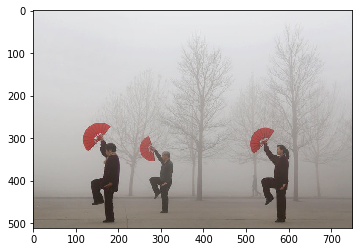

In [15]:
img = imread('pollute.jpg')
plt.imshow(img)

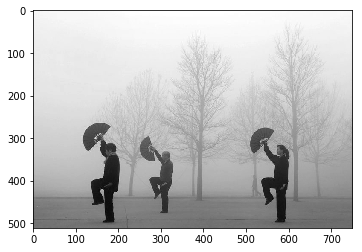

In [16]:
imgGray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
plt.imshow(imgGray, cmap="gray") #change to gray scale 

In [17]:
class Channel_value: 
    val = -1.0 
    intensity = -1.0 

He et al. discovered the dark channel prior. Dark channel prior represents the idea that in most non-sky image areas, at least one color channel has pixels with the lowest intensity. In regular haze free images, 75% of the pixels in the dark channels had zero values and the intensities of 90% of the pixels were below 25. 

However, the dark channels in foggy images are not as dark. Due to added light, the images are bighter and will thus have a higher intensity. This means that the intensity of the dark channel represents the fog density and the object's distance from the camera. 

In [18]:
def find_dark_channel(img): 
    return np.unravel_index(np.argmin(img), img.shape)[2]

How do you measure the atmospheric light intensity? 

Step 1: find the top 0.1% brightest pixels in the dark channels   
Step 2: Choose the one with the highest intensity


In [19]:
def find_intensity_of_atm_light(img, gray): 
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)
    
    #loop through the matrix to find a pixel with a lower
    #value and intensity
    for y in range(img.shape[0]): 
        for x in range(img.shape[1]): 
            val = img.item(y,x,dark_channel)
            intensity = gray.item(y,x)
            for a in toplist: 
                if a.val < val or (a.val == val and a.intensity < intensity): 
                    a.val = val 
                    a.intensity = intensity
                    break 
                    
    #then find the top brightest pizels in the dark channel
    max_channel = Channel_value()
    for a in toplist: 
        if a.intensity > max_channel.intensity: 
            max_channel = a
    return max_channel.intensity 


In [20]:
def clamp(minimum, x, maximum): 
    return max(minimum, min(x, maximum))

In [21]:
light_intensity = find_intensity_of_atm_light(img, imgGray)
print(light_intensity)

235.08200073242188


In [22]:
w = 0.95 
t0 = 0.55

In [23]:
def dehaze(img, light_intensity, windowSize, t0, w): 
    size = (img.shape[0], img.shape[1])#dimensions
    outimg = np.zeros(img.shape, img.dtype)
    for y in range(size[0]): 
        for x in range(size[1]): 
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y + (windowSize//2), size[0])
            
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            
            #estimate the transmission map 
            t = 1.0 - (w * img.item(y,x,dark_channel)/light_intensity)
            
            #clarify the image 
            outimg.itemset((y,x,0), clamp(0, ((img.item(y,x,0) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,1), clamp(0, ((img.item(y,x,1) - light_intensity) / max(t, t0) + light_intensity), 255))
            outimg.itemset((y,x,2), clamp(0, ((img.item(y,x,2) - light_intensity) / max(t, t0) + light_intensity), 255))

    return outimg

In [27]:
imgDeHaze = dehaze(img, light_intensity, 100, t0, w)

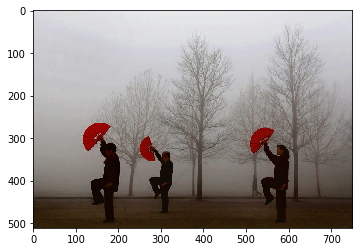

In [28]:
plt.imshow(imgDeHaze)

Text(0.5, 1.0, 'New Image')

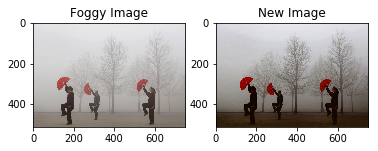

In [34]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Foggy Image")
ax[1].imshow(imgDeHaze, cmap='gray')
ax[1].set_title("New Image")

It looks like our dehazing algorithm works very well. Let's try to fix low-light images now. 

First we invert the image then apply the hazing algorithm we explained above. Then we finally invert the image back to its original color. 

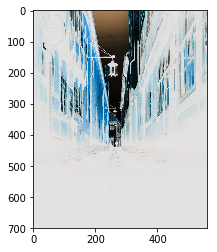

In [35]:
img2 = imread('low_light.jpg')
imgInvert = 255 - img2
plt.imshow(imgInvert)

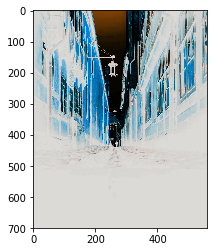

In [36]:
imgDeHaze2 = dehaze(imgInvert, light_intensity, 20, t0, w)
plt.imshow(imgDeHaze2)

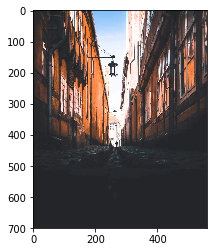

In [32]:
imgBack = 255 - imgDeHaze2
plt.imshow(imgBack)

Text(0.5, 1.0, 'New Image')

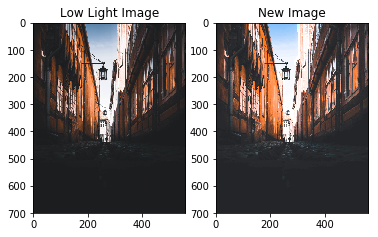

In [33]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(img2, cmap='gray')
ax[0].set_title("Low Light Image")
ax[1].imshow(imgBack, cmap='gray')
ax[1].set_title("New Image")